In [20]:
# data engineer
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor
import pandas as pd
import numpy as np
import math
import queue
from pprint import pprint
from sklearn.ensemble import IsolationForest
import datetime
from tqdm import tqdm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings('ignore')
%matplotlib inline
data_folder = '../data/%s'

In [14]:
def cross_validation(X,y,model,model_name):
    my_pipeline = make_pipeline(SimpleImputer(), model)
    scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error',cv=4)
    print(scores)
    print('%s: '%model_name)
    print('Mean Absolute Error %3f\n' % (-1 * scores.mean()))
    
def models_selection(X,y):
#     cross_validation(X, y.values.ravel(),XGBRegressor(),'XGBRegressor')
    
    cross_validation(X, y.values.ravel(), 
                     ExtraTreesRegressor(n_estimators=500, random_state=0),'ExtraTreesRegressor')
    
    cross_validation(X, y.values.ravel(), 
                     RandomForestRegressor(n_estimators=500,random_state=0),'RandomForestRegressor')
    
    cross_validation(X, y.values.ravel(), 
                     AdaBoostRegressor(n_estimators=500, random_state=0),'AdaBoostRegressor')
    
    universal_model = MLPRegressor(hidden_layer_sizes=(5,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01)
    cross_validation(X, y.values.ravel(),universal_model,'MLPRegressor')
    
    cross_validation(X, y.values.ravel(),linear_model.LinearRegression(),'LinearRegression')

In [17]:
# In[2]:


df_train = pd.read_csv(data_folder % 'train_final.csv')
df_train['date'] = pd.to_datetime(df_train['transcationDate'])
df_train = df_train.set_index('transcationDate').sort_index()
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train = df_train.reset_index()
df_train.columns


# In[3]:


LABEL = 'princeInHKD'
need_features_with_label = ['districtL', 'districtS','floor', 'dis_mtr',
       'dis_school', 'dis_market', 'areaSize', 'year', 'month', 'day','princeInHKD']

cate_features = ['districtL', 'districtS']
num_features = ['floor', 'dis_mtr','dis_school', 'dis_market', 'areaSize']
date_features = ['year', 'month', 'day']
df_train = df_train[need_features_with_label]
df_train.head()


# In[4]:


df_train['districtL'] = df_train['districtL'].replace('HK','Hong Kong').replace('KL','Kowloon')
df_train['floor'] = df_train['floor'].replace('G','0').astype('int64')


# In[5]:


mean = df_train[num_features].mean()
std = df_train[num_features].std()
label_nor = 20


# # In[6]:


df_train[num_features] = (df_train[num_features] - mean) / std
df_train[LABEL] = np.log(df_train[LABEL]) / label_nor


# # In[7]:


# # df_train[LABEL].describe()


# # In[8]:


# split_num = -1000
# df_train_copy = pd.get_dummies(df_train)
# train_data = df_train_copy[:split_num]
# test_data = df_train_copy[split_num:]
# test_data.head()


# # In[9]:


# train_X = train_data.drop(LABEL,axis = 1)
# train_y = train_data[LABEL]
# val_X = test_data.drop(LABEL,axis = 1)
# val_y = test_data[LABEL]

In [12]:
models_selection(train_X[:10000],train_y[:10000])

[-0.0103665  -0.00744911 -0.00795999 -0.01071204]
ExtraTreesRegressor: 
Mean Absolute Error 0.009122

[-0.01027481 -0.00744757 -0.00791814 -0.0113053 ]
RandomForestRegressor: 
Mean Absolute Error 0.009236

[-0.02346236 -0.03132696 -0.03031218 -0.02962982]
AdaBoostRegressor: 
Mean Absolute Error 0.028683

[-0.02025798 -0.03133608 -0.0315344  -0.04191494]
MLPRegressor: 
Mean Absolute Error 0.031261

[-0.01492791 -0.01556251 -0.01426113 -0.01773662]
LinearRegression: 
Mean Absolute Error 0.015622



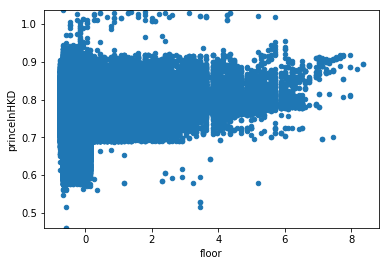

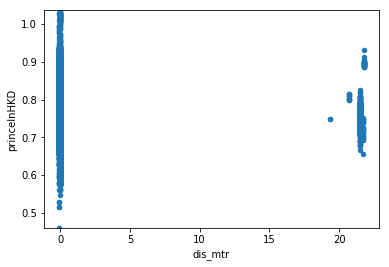

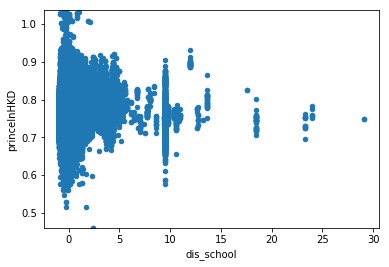

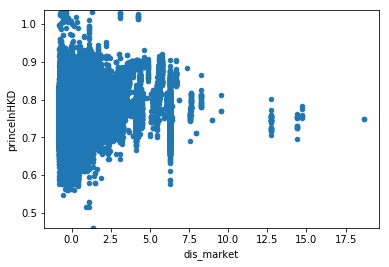

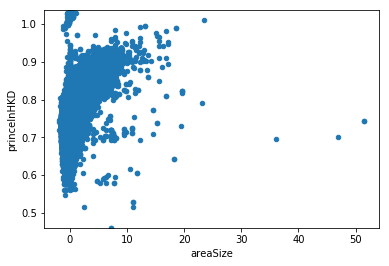

In [18]:
columnsList_num = num_features
for i in columnsList_num:
    var = i
    data = pd.concat([df_train[LABEL], df_train[var]], axis=1)
    data.plot.scatter(x=var, y=LABEL, ylim=(df_train[LABEL].min(),df_train[LABEL].max()))

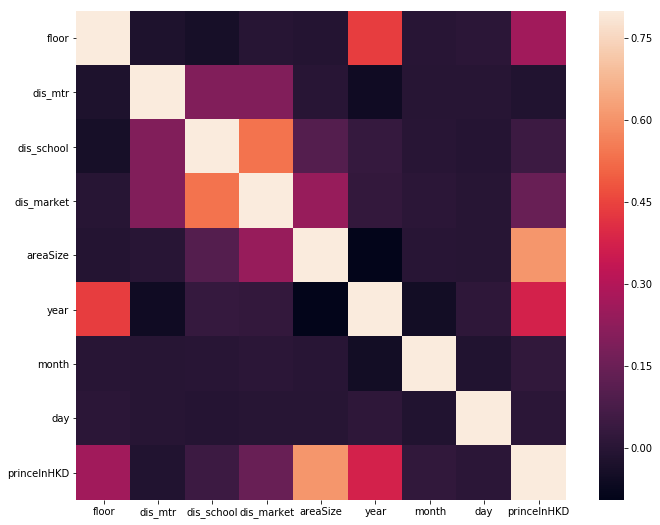

In [21]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

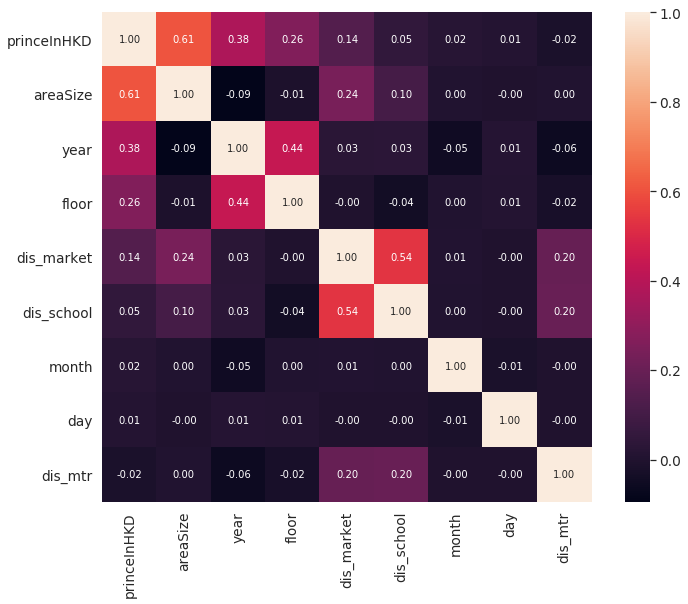

In [22]:
k = 14 #number of variables for heatmap
cols = corrmat.nlargest(k, LABEL)[LABEL].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

(-0.5, 4.5, 0.4, 1)

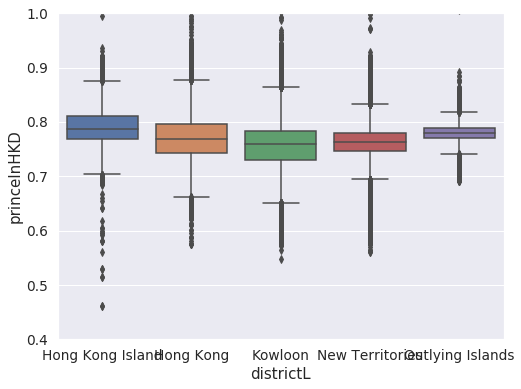

In [26]:
var = 'districtL'
data = pd.concat([df_train[LABEL], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=LABEL, data=data)
fig.axis(ymin=0.4, ymax=1)

(-0.5, 114.5, 0.4, 1)

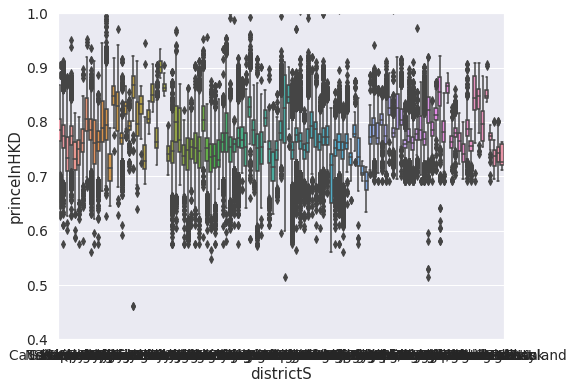

In [27]:
var = 'districtS'
data = pd.concat([df_train[LABEL], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=LABEL, data=data)
fig.axis(ymin=0.4, ymax=1)

In [28]:
df_train.isnull().any()

districtL      False
districtS      False
floor          False
dis_mtr        False
dis_school     False
dis_market     False
areaSize       False
year           False
month          False
day            False
princeInHKD    False
dtype: bool